# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [0]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [0]:
[rng() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

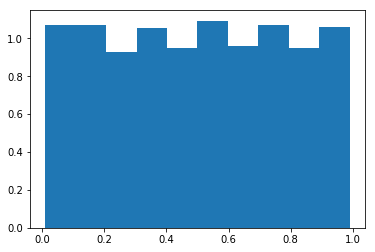

In [5]:
import matplotlib.pyplot as plt
plt.hist(random, density=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

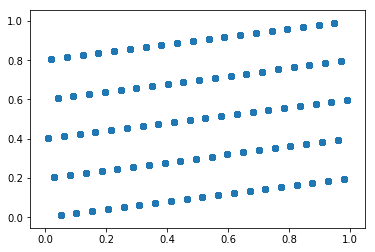

In [0]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

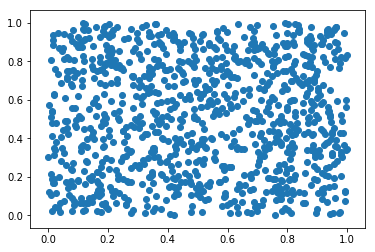

In [0]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


0.05467489599959663


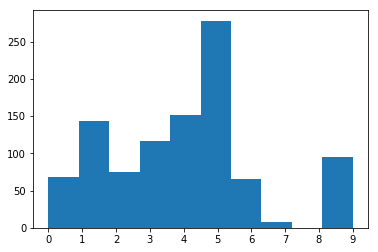

In [4]:
# Solution here
import timeit
import numpy as np
import matplotlib.pyplot as plt
vesa=np.array([ 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
vesa=vesa/sum(vesa)  #отнормировали веса
A=np.random.rand(1000) 
B=np.zeros(1000)
a = timeit.default_timer()
for i in range (1000):
    for j in range(10):
        if(sum(vesa[0:j])<=A[i]<sum(vesa[0:j+1])): #если случайное число попало в отрезок j, то присвоим ему номер j
            B[i]=j
print(timeit.default_timer()-a)
plt.hist(B) 
plt.xticks(np.arange(10))
plt.show()


0.06949800900000014


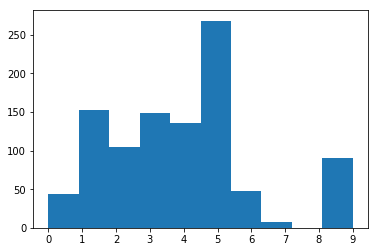

In [4]:
#теперь отсортируем веса не забыв, каким номерам они соответствовали
vesa_sort=np.sort(vesa)[::-1]
B=np.zeros(1000)
a = timeit.default_timer()
for i in range (1000):
     for j in range(10):
        if(sum(vesa_sort[0:j])<=A[i]<sum(vesa_sort[0:j+1])):
            B[i]=np.argsort(vesa)[::-1][j]
print(timeit.default_timer()-a)
plt.hist(B) 
plt.xticks(np.arange(10))
plt.show()


###### кажется, это просто реализация функции np.random.choice

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

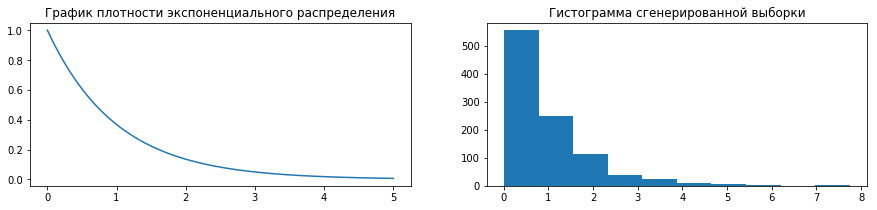

[0.5730598739775316,
 0.5763453899073469,
 1.6145793784356344,
 2.8515179600314924,
 0.4262470609778963,
 2.759268131487275,
 1.3682495446350693,
 0.3064171014102619,
 0.9118968057605059,
 0.8628156732374453,
 1.3396823715883477,
 0.7603109651234734,
 0.647365272386699,
 1.1209576754040784,
 1.3607525974775263,
 0.15105907543332073,
 0.8635197948402747,
 2.9116820149190934,
 0.9414868436110929,
 0.8850478715363755,
 0.2275414341243053,
 0.8610228092757758,
 0.32401862270000203,
 0.023717654254149276,
 0.35277882423033885,
 2.85223443038786,
 0.7348161080313859,
 0.39746556332338845,
 0.3728381910486073,
 1.105543225847709,
 0.14193897864296584,
 0.5799283838262804,
 0.13352731079985075,
 0.07265566665693403,
 1.1629069157181915,
 0.530272396366486,
 5.266404747851596,
 0.23785102785677725,
 0.7420959000931268,
 0.21990684318096795,
 0.35791364154929084,
 1.9051709204548821,
 0.0634302796472384,
 1.9160619463675441,
 0.9937257022233916,
 0.5855098168632279,
 0.44013285316225575,
 0.6968

In [108]:
# Solution here
import math as m
def expon(x,a):
    if (x>=0):
        return m.exp(-a*x)*a
    else:
        return 0
def exp_reverse(x,a):
    return m.log(1-x)/(-a)
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15, 3))
exp=[exp_reverse(np.random.uniform(),1) for i in range(1000)]
x=np.linspace(0,5,1000)
ax1.plot(x,[expon(x[i],1) for i in range(1000)])
ax1.set_title('График плотности экспоненциального распределения')
ax2.hist(exp)
ax2.set_title("Гистограмма сгенерированной выборки")
plt.show()
exp

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

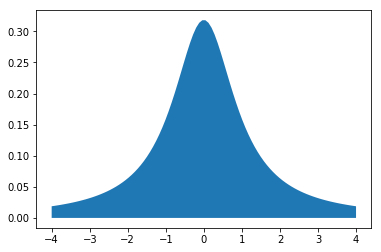

In [5]:
from scipy import stats
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

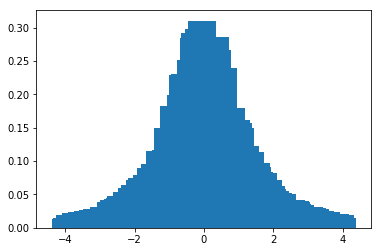

In [10]:
# Solution here
#смоделируем 1000 точек для плотности Коши
x =np.random.uniform(-4, 4, 1000)
#x=np.linspace(-4,4,1000)
s=[]
for i in range (1000):
    while len(s)<i+1:
        samp1=np.random.uniform(0,dist.pdf(0))
        if(samp1<=dist.pdf(x[i])):            s.append(samp1)
plt.bar(x,s)
plt.show()

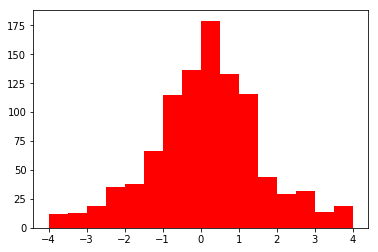

In [35]:
#посмотрим на полученную выборку
y= np.array(s)
y=y/sum(y)
sample=np.random.choice(x,size=1000,p=y)
plt.hist(sample,bins=np.arange(-4,4.5,0.5),color='r')
plt.show()


##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

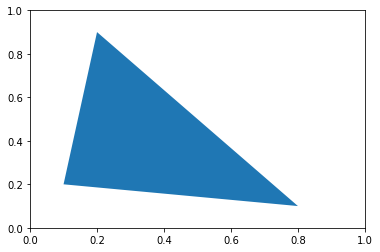

In [102]:
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
def func():
    x,y=sorted([np.random.rand(),np.random.rand()])
    return (x * 0.1 + (y-x)*0.2 + (1-y)*0.8, x * 0.2 + (y-x)*0.9 + (1-y)*0.1)
s=[func() for i in range (500)]
s=np.array(s)

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.show()

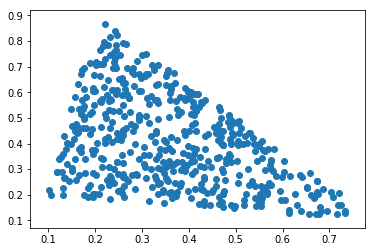

In [103]:
plt.scatter(s[:,0], s[:,1])
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

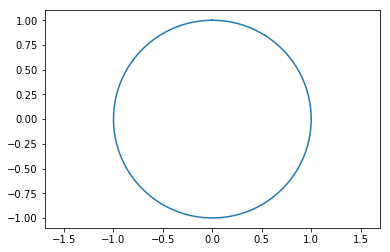

In [0]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

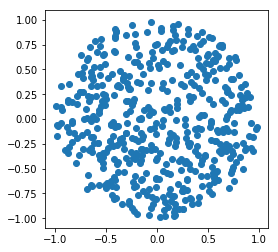

In [125]:
# Solution here
r=np.sqrt(np.random.rand(500))
phi=np.random.rand(500)
plt.figure(figsize=(4, 4))
plt.scatter(r*np.cos(2*np.pi*phi),r*np.sin(2*np.pi*phi))
plt.show()


### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

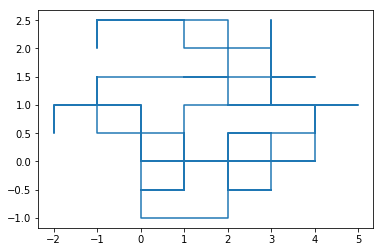

In [54]:
# Solution here
def rwalk(n):
  #повернем сетку на 45 градусов чтобы движения на плоскости стали независимыми: т.е точка в след момент времени 
# может перейти в (1,1),(-1,1),(-1,-1) или (1,-1). Потом повернем обратно.
    x,y=(np.ones(n),np.ones(n))
    ind1=np.random.choice(np.arange(n),size=n//2,replace=False)
    ind2=np.random.choice(np.arange(n),size=n//2,replace=False)
    x[ind1]=-1
    y[ind2]=-1
    x=np.cumsum(x)
    y=np.cumsum(y)
    x=(x+y)/2
    y=(x-y)/2
    x=np.insert(x,0,0)
    y=np.insert(y,0,0)
    plt.plot(x,y)
    plt.show() 
rwalk(100)

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модивицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

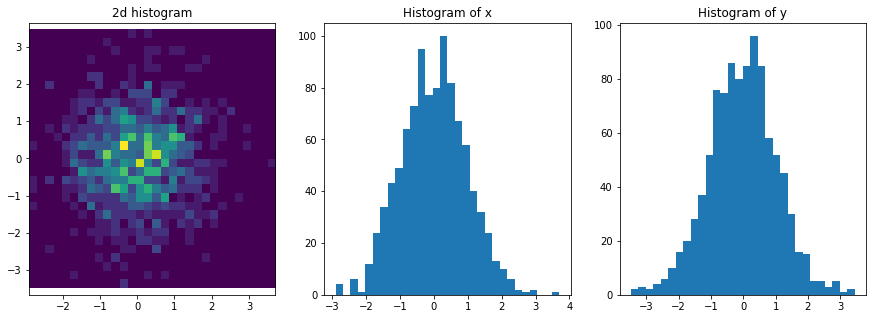

In [0]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

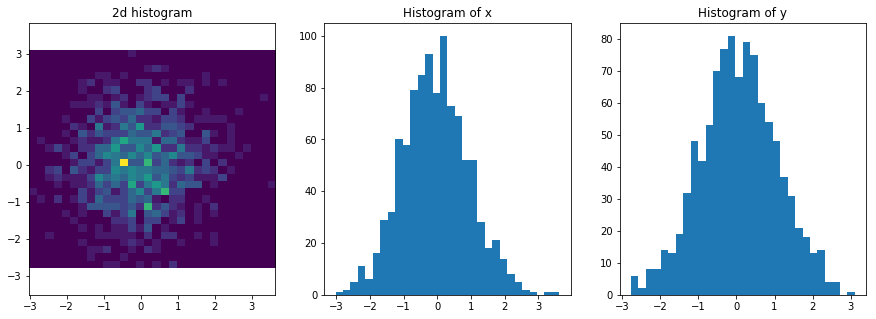

In [59]:
# Solution here, модификация:
n = 1000
u1=np.array([])
u2=np.array([])
R=np.array([])
for i in range (n):
    while len(u1)<i+1:
        x,y=np.random.uniform(-1,1,2)
        r=x**2+y**2
        if(0<r<=1):            
            u1=np.append(x,u1)
            u2=np.append(y,u2)
            R=np.append(r,R)

k = np.sqrt((-2 * np.log(R))/R)
x = u1 * k
y = u2 * k
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

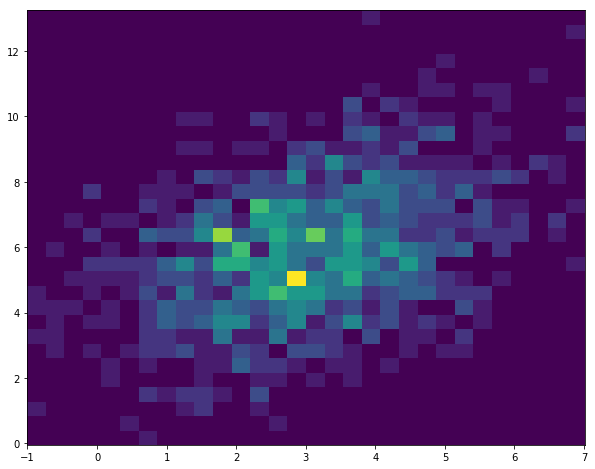

In [60]:
#сейчас имеем двумерный вектор (0,E). надо построить вектор ((3,6) - матожидание, ((2, 1), (1, 4)) - ковариационная матрица)
#для этого надо сделать преобразование A*x+b, где b - вектор ожиданий.A такая, что А*A^T=наша искомая ковариационная матрица
x1= (1/2)*x+(np.sqrt(7)/2)*y+3 #сдвинули на матожидание и умножили на матрицу, которая находится через решение системы
y1=2*x+6
fig = plt.figure(figsize=(10,8))
plt.hist2d(x1, y1, bins=30)
plt.show()

## Практическое задание

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [159]:
# Solution here
n=100
def subset (n):
    B=0
    for k in range (171):
        B=B+(k**n)/(np.math.factorial(k)*np.exp(1))
    K=np.random.choice(np.arange(1,n+1),p=[k**n/(B*np.exp(1)*np.math.factorial(k)) for k in range (1,n+1)])
    return np.random.choice(np.arange(1,K+1),size=n)
subset(n)

array([16, 26, 20, 27, 28, 28, 15,  3,  9,  5, 28, 16, 26,  1, 12,  4, 22,
        3, 23, 24, 25, 16, 15, 24,  6, 12,  5,  5, 20, 23, 25, 17,  5, 26,
        2, 15, 26,  9,  9, 15, 10, 22, 18, 22,  1, 12, 18, 20,  4, 27, 12,
       17, 17,  9, 10,  7, 19,  8, 23, 29, 12,  4, 23, 15, 29, 17, 17,  9,
       13, 16,  8, 14, 12, 29, 15, 26, 22, 14, 22, 10, 18, 10, 24, 11, 16,
        6, 18, 24, 29, 23, 17,  7,  4, 28, 20, 29,  2,  2, 21,  5])

In [162]:
C=[len(np.unique(subset(n))) for k in range(1000)]
np.mean(C)

28.601